[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/experimental/semantic-search-filtering/semantic-search-with-filtering.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/experimental/semantic-search-filtering/semantic-search-with-filtering.ipynb)

# Text search with metadata filtering (Example)

This notebook demonstrates how to use Pinecone's metadata filtering feature to refine similarity results.

The goal is to create a search algorithm that retrieves similar news articles based on text queries and metadata filters.
Metadata filters enhance our queries to retrieve the articles that satisfy some user-defined conditions.
**Imagine this query:**  

*I want similar articles about "The Lord of the Rings" but published by "Los Angeles Times" from 2015 to 2018 as a newspaper article.*  

Pinecone query can do just that. It finds articles that match conditions on a publisher, year range, category, etc. It returns you a sorted list of scored articles. Just specify filtering conditions in a query, and Pinecone will see it done. No need for manual refinement of the results. Powerful, right?

**How do we achieve this?**  
We need to store vector representations of the articles in Pinecone's index. These vectors and their proximity capture semantic relations. Nearby vectors indicate similar content, and contents from faraway vectors are dissimilar. We can enrich each vector with a metadata map (such as category, year, publication). Having metadata embedded in a vector opens the door to metadata filtering in queries. 

Semantic textual search is a technique used for solving other text-based applications. For example, our deduplication, question-answering, and personalized article recommendation demos are solved using semantic textual search.

## Install libraries and import

In [ ]:
!pip install -qU pinecone-client 
!pip install -qU ipywidgets
!pip install -qU pandas
!pip install -qU sentence-transformers --no-cache-dir
!pip install -qU wordcloud

In [1]:
import os
import pinecone
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import sqlite3
from itertools import islice
from sentence_transformers import SentenceTransformer
from typing import Dict, Any, Mapping, Optional, Callable, Iterator, Tuple, Iterable, List
from pinecone import Index, QueryVector, Vector, QueryResult

pd.set_option('display.max_colwidth', 200)

## Initialize pinecone clinet

Get API key from [here](https://www.pinecone.io/start/) if you don't have it already.

In [2]:
api_key = os.getenv("PINECONE_API_KEY") or "YOUR-API-KEY"
pinecone.init(api_key=api_key, environment='us-west1-gcp')
pinecone.list_indexes()

[]

## Create a new index service

In [4]:
index_name = 'semantic-text-search-filter'

In [5]:
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)
dimension = 300
pinecone.create_index(index_name, dimension, metric='cosine', shards=1)

In [ ]:
index = pinecone.Index(index_name = index_name)

## Upload vectors with metadata
We will define two separate sub-indexes using Pinecone's namespace feature. One for indexing articles by content, and the other by title. At query time, we will return an aggregation of the results from the content and title indexes.

First, we will load data and the model, and then create vectors and upsert them alongside with metadata into the namespaces.

### Load Data
The [dataset](https://components.one/datasets/all-the-news-articles-dataset) used throughout this example contains 200k+ articles from 18 American publications.

In [ ]:
!wget https://www.dropbox.com/s/b2cyb85ib17s7zo/all-the-news.db -q --show-progress

We are loading dataset into a Pandas DataFrame.

In [8]:
cnx = sqlite3.connect('all-the-news.db')
all_data = pd.read_sql_query("SELECT * FROM longform", cnx)
all_data.set_index('id', inplace=True)
cnx.close()

In [9]:
# Make a test set for matchin queries later
NUM_OF_TEST_ARTICLES = 10
test_articles = all_data.head(NUM_OF_TEST_ARTICLES).copy()
data = all_data.drop(list(test_articles.index))

test_articles.head()

,title,author,date,content,year,month,publication,category,digital,section,url
id,,,,,,,,,,,
1,"Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating",\nTasha Robinson\n,2017-05-31,"And never more so than in Showtime’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st, Showtime brought back David Lynch’s groundbreaking TV se...",2017,5,Verge,Longform,1.0,None,None
2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s ...,2017,5,Verge,Longform,1.0,None,None
3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,"Super Deluxe built a weird internet empire. Can it succeed on TV? When Wolfgang Hammer talks about the future of entertainment, people listen. Hammer is the mastermind behind the American re...",2017,5,Verge,Longform,1.0,None,None
4,How Anker is beating Apple and Samsung at their own accessory game,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the world needed: a line of reasonably priced accessories that would be better than the ones you could ...,2017,5,Verge,Longform,1.0,None,None
5,Tour Black Panther’s reimagined homeland with Ta-Nehisi Coates,\nKwame Opam\n,2017-05-15,"Ahead of Black Panther’s 2018 theatrical release, Marvel turned to Ta-Nehisi Coates to breathe new life into the nation of Wakanda. “I made most of my career analyzing the forces of racism a...",2017,5,Verge,Longform,1.0,None,None


In [10]:
data.head()

,title,author,date,content,year,month,publication,category,digital,section,url
id,,,,,,,,,,,
11,Signal Boost,\nLauren Smiley\n,2017-01-12,"Demand for secret messaging apps is rising as Trump takes office Two weeks after the US presidential election, Reverend Rebecca Bryan stepped up to her pulpit in the Boston suburb of Brookli...",2017,1,Verge,Longform,1.0,None,None
12,Cracking the elaborate code,\nBen Popper\n,2016-12-07,"To get to the Panoptic Studio at Carnegie Mellon University, you take an elevator down four flights to a dingy sub-basement. Inside room B510, a series of metal cross beams enclose a massive...",2016,12,Verge,Longform,1.0,None,None
13,Building tools for digital activism,\nKwame Opam\n,2016-11-29,"The Verge 2021In celebration of our 5th anniversary, this month we’re publishing a series of interviews with innovative leaders about what the next five years hold. To read more about this s...",2016,11,Verge,Longform,1.0,None,None
15,Gene editing will transform cancer treatment,\nElizabeth Lopatto\n,2016-11-22,"The Verge 2021In celebration of our 5th anniversary, this month we’re publishing a series of interviews with innovative leaders about what the next five years hold. To read more about this s...",2016,11,Verge,Longform,1.0,None,None
16,Flying cars are closer than you think,\nCasey Newton\n,2016-11-21,"The Verge 2021In celebration of our 5th anniversary, this month we’re publishing a series of interviews with innovative leaders about what the next five years hold. To read more about this s...",2016,11,Verge,Longform,1.0,None,None


Lets see what are all posible entires for our metadata

In [11]:
print('Category', set(data['category']))
print('Year', set(data['year']))
print('Publication', set(data['publication']))

Category {'Longform', 'broadcast', None, 'radio', 'newspaper', 'general', 'wire', 'Reports', 'Exclusive', 'Book Reviews', 'business'}
Year {'', None, 2000, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}
Publication {'New Inquiry', 'Breitbart', 'National Review', 'Business Insider', 'New York Times', 'Guardian', 'Vox', 'Los Angeles Times', 'Fox News', 'NPR', None, 'Buzzfeed News', 'CNN', 'Talking Points Memo', 'Atlantic', 'Verge', 'Reuters', 'Washington Post', 'New York Post'}


### Model Transformer

To create vectors (embeddings) we will use: [Average word embeddings model](https://www.sbert.net/docs/pretrained_models.html#average-word-embeddings-models). 

We will wrap a model into a `ModelTransformer` class so we can reuse functionality of encoding text to embeddings. 

In [14]:
def format_values(vector: Iterable) -> str:
    if not vector:
        return '[]'
    return '[' + ', '.join(str(el) for el in islice(vector, 0, 3, 1)) + ', ... ]'

class ModelTransformer:
    """ Wraps a sentence transformer model. """
    
    def __init__(self, model: SentenceTransformer) -> None:
        self.model = model
    
    def preprocess(self, text: Optional[str]) -> str:
        """ Runs basic preprocessing on the input text. """
        ret: str = ''
        if text is not None:
            ret = (
             text.strip()
            .lower()
            .replace('xa0b', ' ')
            .replace('xa0', ' ')
            .replace('amprsquo', '\'')
            .replace('amprdquo', '"')
            .replace('ampmdash', '-')
        )
        return ret
    
    def encode_single(self, text: Optional[str]) -> List[float]:
        """ Runs a sentence transfomer over a input text. """
        return self.model.encode(
            self.preprocess(text), show_progress_bar=False).tolist()
    
    def encode_batch(self, batch: pd.Series) -> List[List[float]]:
        """ Runs a sentence transformer over a batch of text. """
        return self.model.encode(
            batch.apply(self.preprocess).tolist(), show_progress_bar=True).tolist()

def print_transformer(transformer: ModelTransformer, data: pd.DataFrame) -> None:
    """ A helper method to see how model transformer works. """
    print('Hello World', format_values(transformer.encode_single('Hello World')))
    print('None', format_values(transformer.encode_single(None)))
    sample_data = data[:5].copy()
    sample_data_encoded = transformer.encode_batch(sample_data['title'])
    print('5 titles encode as batch:')
    for encoded in sample_data_encoded:
        print(format_values(encoded))   

transformer = ModelTransformer(SentenceTransformer('average_word_embeddings_komninos'))
print_transformer(transformer, data)

Hello World [-0.020873993635177612, 0.28058600425720215, 0.22973251342773438, ... ]
None [0.0, 0.0, 0.0, ... ]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5 titles encode as batch:
[0.511946976184845, 0.07776249945163727, -0.23178298771381378, ... ]
[0.23699401319026947, -0.37649965286254883, -0.14324899017810822, ... ]
[0.3888619840145111, 0.06639300286769867, -0.18874074518680573, ... ]
[0.2522968053817749, 0.04442639276385307, 0.06622680276632309, ... ]
[0.11001875251531601, 0.06452524662017822, 0.09645550698041916, ... ]


### Helper class for vector creation

Now, we can reuse our `ModelTransformer` in `VectorPreprocessing` class to create a list of `Vector` instances from input pandas DataFrame.
Each `Vector` instance will contain:
1. `id` - an index of the pandas row
2. `values` - an embeddings after transforming text (`titles` or `contents`)
3. `metadata` - a dictionary of metadata for the vector

In [15]:
def shorten_vector(vector: Vector) -> str:
    """ A helper method to format vector values. """
    return (
        f'Vector(id={vector.id}, '
        f'values={format_values(vector.values)}, '
        f'metadata={vector.get("metadata")})'
    )

class VectorPreprocessing:
    """ 
        Models a vector preprocessing which takes 
        an input DataFrame and produces a list of embeddings. 
    """
    YEAR_COL = 'year'
    PUBLICATION_COL = 'publication'
    CATEGORY_COL = 'category'
    
    def __init__(
            self, 
            transformer: ModelTransformer,
            text_col: str) -> None:
        self.transformer = transformer
        self.text_col = text_col
    
    def format_id(self, raw_id: Any) -> str:
        return str(raw_id)
    
    def extract_metadata(self, row: Mapping[str, Any]) -> Dict[str, Any]:
        """ Makes a metadata dictionary for a vector. """
        ret: Dict[str, Any] = dict()
        publication = row[self.PUBLICATION_COL]
        year = str(row[self.YEAR_COL])
        category = row[self.CATEGORY_COL]
        if year and year.isdigit():
            ret['year'] = int(year)
        
        ret['publication'] = publication.lower() if publication else 'N/A'
        ret['category'] = category.lower() if category else 'N/A'
        return ret
    
    def prepare_vector(self, row: pd.Series) -> Vector:
        """ Prepares a single vector out of pandas DataFrame's row. """
        return Vector(
            id=self.format_id(row.name), 
            values=self.transformer.encode_single(row[self.text_col]),
            metadata=self.extract_metadata(row)
        )
    
    def prepare_vectors(self, df: pd.DataFrame) -> List[Vector]:
        """ Transforms a pandas DataFrame to the list of vectors. """
        return df.apply(self.prepare_vector, axis=1).tolist()
    
    __call__ = prepare_vectors


def print_prepare(
        preprocessing: VectorPreprocessing, data: pd.DataFrame) -> None:
    """ A helper function to visualize several vectors. """
    for vector in preprocessing(data):
        print(shorten_vector(vector))

sample_data = data[:5].copy()
print_prepare(VectorPreprocessing(transformer, 'content'), sample_data)
print('Validate empty year')
print_prepare(VectorPreprocessing(transformer, 'content'), data[data['year'] == ''][:2])
print('Validate null year')
print_prepare(VectorPreprocessing(transformer, 'content'), data[data['year'].isnull()][:2])
print('Validate null category')
print_prepare(VectorPreprocessing(transformer, 'content'), data[data['category'].isnull()][:2])

Vector(id=11, values=[0.10000026226043701, 0.034198783338069916, 0.04728506878018379, ... ], metadata={'year': 2017, 'publication': 'verge', 'category': 'longform'})
Vector(id=12, values=[0.12866811454296112, 0.07271476089954376, 0.011061795055866241, ... ], metadata={'year': 2016, 'publication': 'verge', 'category': 'longform'})
Vector(id=13, values=[0.1215154305100441, 0.044188372790813446, 0.0500008799135685, ... ], metadata={'year': 2016, 'publication': 'verge', 'category': 'longform'})
Vector(id=15, values=[0.12178155779838562, 0.03757135570049286, 0.04363948106765747, ... ], metadata={'year': 2016, 'publication': 'verge', 'category': 'longform'})
Vector(id=16, values=[0.12423300743103027, 0.05911443009972572, 0.04855823889374733, ... ], metadata={'year': 2016, 'publication': 'verge', 'category': 'longform'})
Validate empty year
Vector(id=82749, values=[0.1549619734287262, -0.03321565315127373, 0.002968846121802926, ... ], metadata={'publication': 'fox news', 'category': 'broadcas

### Helper class for batch upsert

We don't want to upsert all vectors at once (200k+) nor we want to upsert vector by vector, so we need a simple `BatchGenerator` which will split our DataFrame into smaller DataFrame chunks.

In [16]:
class BatchGenerator:
    """ Models a simple batch generator that make chunks out of an input DataFrame. """
    
    def __init__(self, batch_size: int = 10) -> None:
        self.batch_size = batch_size
    
    def to_batches(self, df: pd.DataFrame) -> Iterator[pd.DataFrame]:
        """ Makes chunks out of an input DataFrame. """
        splits = self.splits_num(df.shape[0])
        if splits <= 1:
            yield df
        else:
            for chunk in np.array_split(df, splits):
                yield chunk
    
    def splits_num(self, elements: int) -> int:
        """ Determines how many chunks DataFrame contians. """
        return round(elements / self.batch_size)
    
    __call__ = to_batches


def print_batcher(df: pd.DataFrame) -> None:
    """ A helper function that shows how a simple batcher works. """
    batcher = BatchGenerator(batch_size=10)
    for batch_i, batch in enumerate(batcher(df)):
        print(f'--- batch {batch_i}, contains {batch.shape[0]} entries ---')
print_batcher(data[:21].copy())  

--- batch 0, contains 11 entries ---
--- batch 1, contains 10 entries ---


### Content upsert

After we have all helper functions and classes, let's upsert content vectors into `content` namespace.

First we take a DataFrame and run it through our `BatchGenerator`. Every batch is processed using our `VectorPreprocessing`. The output of the `VectorPreprocessing` for every batch is list of `Vector` instances that we send to the `index` using `index.upsert` method.

In [ ]:
CONTENT_NAMESPACE = 'content'
batcher = BatchGenerator(batch_size=500)
content_preprocessor = VectorPreprocessing(transformer, 'content')
index = pinecone.Index(index_name = index_name)

for batch_i, batch in enumerate(batcher(data)):
    vectors = content_preprocessor(batch)
    index.upsert(vectors, namespace=CONTENT_NAMESPACE)
    print(f'upserted batch {batch_i} of {batch.shape[0]} vectors')

Let's verify how our index looks like using `index.describe_index_stats()` method. We can also fetch and see upserted vectors using `index.fetch` method.

In [18]:
index.describe_index_stats()

{'dimension': 300, 'namespaces': {'content': {'vector_count': 204125}}}

In [19]:
vectors = index.fetch(['11', '12'], namespace=CONTENT_NAMESPACE).vectors
for _, vector in vectors.items():
    print(shorten_vector(vector))

Vector(id=12, values=[0.128668115, 0.0727147609, 0.0110617951, ... ], metadata={'publication': 'verge', 'category': 'longform', 'year': 2016.0})
Vector(id=11, values=[0.100000262, 0.0341987833, 0.0472850688, ... ], metadata={'year': 2017.0, 'category': 'longform', 'publication': 'verge'})


### Title upsert

After we have all helper functions and classes, let's upsert title vectors into `title` namespace.

First we take a DataFrame and run it through our `BatchGenerator`. Every batch is processed using our `VectorPreprocessing`. The output of the `VectorPreprocessing` for every batch is list of `Vector` instances that we send to the `index` using `index.upsert` method.

In [ ]:
TITLE_NAMESPACE = 'title'
batcher = BatchGenerator(batch_size=500)
title_preprocessor = VectorPreprocessing(transformer, 'title')
index = pinecone.Index(index_name = index_name)

for batch_i, batch in enumerate(batcher(data)):
    vectors = title_preprocessor(batch)
    index.upsert(vectors, namespace=TITLE_NAMESPACE)
    print(f'upserted batch {batch_i} of {batch.shape[0]} vectors')

Again, we can verify how our index looks like using `index.describe_index_stats()` method. We can also fetch and see upserted vectors using `index.fetch` method.

In [21]:
vectors = index.fetch(['11', '12'], namespace=TITLE_NAMESPACE).vectors
for _, vector in vectors.items():
    print(shorten_vector(vector))

Vector(id=11, values=[0.511947, 0.0777625, -0.231782988, ... ], metadata={'year': 2017.0, 'publication': 'verge', 'category': 'longform'})
Vector(id=12, values=[0.236994013, -0.376499653, -0.14324899, ... ], metadata={'publication': 'verge', 'category': 'longform', 'year': 2016.0})


In [22]:
index.describe_index_stats()

{'dimension': 300,
 'namespaces': {'content': {'vector_count': 204125},
                'title': {'vector_count': 204125}}}

## Queries

Let's see how we can query a Pinecone index

We created several classes that would help us to query pinecone index, parse and make a summary of the query results.

`DataLookup` - a simple DataFrame lookup using vector id  
`QueryExecutor` - uses our `ModelTransformer` that prepares an input text and runs a `query`  
`ResultParser` - Takes a query results and tranforms it into pandas DataFrame  
`QueryAggregation` - Runs a query for both titles and contents and returns merged results  

In [23]:
class DataLookup:
    """ Models a data frame lookup methods by vector id. """
    
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
    
    def title(self, vector_id: str) -> str:
        return self.record(vector_id).title
    
    def content(self, vector_id: str) -> str:
        return self.record(vector_id).content
    
    def record(self, vector_id: str) -> pd.Series:
        return self.data.loc[int(vector_id)]

class QueryExecutor:
    """ Models a query executor wrapper. """
    def __init__(
            self, 
            transformer: ModelTransformer, 
            index: Index,
            top_k: int = 10) -> None:
        self.index = index
        self.top_k = top_k
        self.transformer = transformer
    
    def query_single(
            self, 
            text: str, 
            filters: Optional[Dict[str, Any]] = None, 
            namespace: str = '') -> QueryResult:
        """ Runs a single query on the input text and filtering rules. """
        filters = filters if filters is not None else dict()
        return index.query([
            self.transformer.encode_single(text)],
            filter=filters,
            namespace=namespace,
            top_k=self.top_k,
            include_values=False,
            include_metadata=True)
    
    __call__ = query_single

class ResultParser:
    """ Models a query result parser. """
    
    def __init__(self, data_lookup: DataLookup) -> None:
        self.data_lookup = data_lookup
    
    def parse(self, query_result: QueryResult) -> pd.DataFrame:
        """ Converts a query results into a pandas DataFrame. """
        data: List[Dict[str, Any]] = list()
        for result in query_result.results:
            for match in result.matches:
                data.append({
                    'vector_id': match.id,
                    'score': match.score,
                    'title': self.data_lookup.title(match.id),
                    'content': self.data_lookup.content(match.id),
                    'year': self.data_lookup.record(match.id).year,
                    'publication': self.data_lookup.record(match.id).publication,
                    'category': self.data_lookup.record(match.id).category
                })
        return pd.DataFrame(data)
    
    __call__ = parse

class QueryAggregation:
    """ Models a query merger. """
    
    def __init__(self, query_executor: QueryExecutor, result_parser: ResultParser) -> None:
        self.query_executor = query_executor
        self.result_parser = result_parser
    
    def summary(self, text: str, filters: Optional[Dict[str, Any]] = None) -> pd.DataFrame:
        """ Runs a query agains two namespaces and merges the results. """
        title_res = self.result_parser(self.query_executor(text, filters, 'title'))
        content_res = self.result_parser(self.query_executor(text, filters, 'content'))
        return pd.concat([title_res, content_res]).drop_duplicates(['vector_id'])
    
    __call__ = summary

""" Helper functions for result visualization. """
def clean(text: str) -> str:
    ret: str = ''
    if text is not None:
        ret = (text.strip()
            .lower()
            .replace('xa0b', ' ')
            .replace('xa0', ' ')
            .replace('amprsquo', '\'')
            .replace('amprdquo', '"')
            .replace('ampmdash', '-')
        )
    return ret

def generate_wordcloud(results: pd.DataFrame) -> WordCloud:
    contents = [clean(text) for text in results.content.values]
    titles = [clean(text) for text in results.title.values]
    wc_text = ' '.join(contents + titles)
    return WordCloud(
        max_words=1000, 
        min_font_size =12, 
        max_font_size=50, 
        relative_scaling = 0.5, 
        stopwords=set(STOPWORDS),
        normalize_plurals= True,
        min_word_length=3,
    ).generate(wc_text)

def plot_wordcloud(wordcloud: WordCloud) -> None:
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_summary(results: pd.DataFrame) -> pd.DataFrame:
    if results.empty:
        print('empty result query')
        return results
    print(results['score'].describe())
    plot_wordcloud(generate_wordcloud(results))
    return results.sort_values(by='score', ascending=False).head(5)

### Let's run a first query

Meerkats, almost everyone finds meerkats adorable. Let's see if there are any related articles that are published after 2014.

In [24]:
data_lookup = DataLookup(data)
test_lookup = DataLookup(test_articles)
query = QueryExecutor(transformer, index)
result_parser = ResultParser(data_lookup)

content_res = result_parser(query('Meerkats', { "year": { "$gt": 2014}}, 'content'))
title_res = result_parser(query('Meerkats', { "year": { "$gt": 2014}}, 'title'))
merged_res = pd.concat([content_res, title_res]).drop_duplicates(['vector_id'])

We can see the results are animal related topics.

In [25]:
merged_res.sort_values(by='score', ascending=False).head(5)

,vector_id,score,title,content,year,publication,category
0,153583,0.700934,10 words that don't mean what they used to: when meerkats were monkeys and bimbos were boys,"It’s by no means unusual for words to change their meaning over time. But thanks to the twists and turns of language – and the convoluted history of English, in particular – some words end up quit...",2016,Guardian,newspaper
1,77065,0.607374,Ringling's Last Elephants,"[, I want to receive updates from partners and sponsors., , Elephants will perform for the last time at Ringling Bros. and Barnum &amp Bailey Circus on Sunday, marking the end of a 200-year tradit...",2016,Atlantic,general
2,219371,0.596522,On Ableism and Animals,The ableism embedded in animal-rights discourse is evident in a common rallying cry used by animal advocates. To be a “voice for the voiceless” is a sentiment with which many activists withi...,2017,New Inquiry,None
3,169006,0.594081,Should We Really Be Keeping Cats And Dogs — And Geckos — As Pets?,"[Bioethicist Jessica Pierce includes pets — or ""animal companions"" — among her family members: a cat, two dogs and fish., So, it's startling to read this passage near the beginning of her new book...",2016,NPR,radio
4,62801,0.588286,The glorious mothers of elephants and whales (Opinion),[ (CNN)Four mother elephants are keeping their rotund babies in the shade of their bodies as they lead them across a sweet-smelling grassland under an already-hot early equatorial sun. Striding wi...,2015,CNN,broadcast


In [26]:
print('Average Score:', np.mean(merged_res['score']))
print('Collected:', merged_res.shape[0])

Average Score: 0.562013272631579
Collected: 19


count    19.000000
mean      0.562013
std       0.043475
min       0.522692
25%       0.531686
50%       0.542008
75%       0.586959
max       0.700934
Name: score, dtype: float64


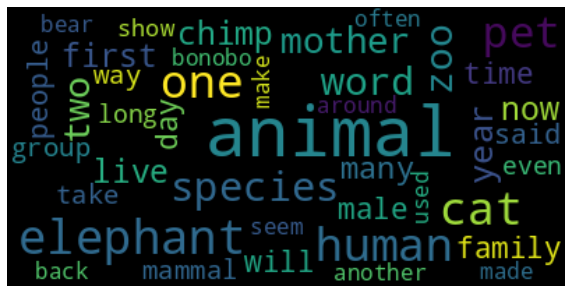

,vector_id,score,title,content,year,publication,category
0,153583,0.700934,10 words that don't mean what they used to: when meerkats were monkeys and bimbos were boys,"It’s by no means unusual for words to change their meaning over time. But thanks to the twists and turns of language – and the convoluted history of English, in particular – some words end up quit...",2016,Guardian,newspaper
1,77065,0.607374,Ringling's Last Elephants,"[, I want to receive updates from partners and sponsors., , Elephants will perform for the last time at Ringling Bros. and Barnum &amp Bailey Circus on Sunday, marking the end of a 200-year tradit...",2016,Atlantic,general
2,219371,0.596522,On Ableism and Animals,The ableism embedded in animal-rights discourse is evident in a common rallying cry used by animal advocates. To be a “voice for the voiceless” is a sentiment with which many activists withi...,2017,New Inquiry,None
3,169006,0.594081,Should We Really Be Keeping Cats And Dogs — And Geckos — As Pets?,"[Bioethicist Jessica Pierce includes pets — or ""animal companions"" — among her family members: a cat, two dogs and fish., So, it's startling to read this passage near the beginning of her new book...",2016,NPR,radio
4,62801,0.588286,The glorious mothers of elephants and whales (Opinion),[ (CNN)Four mother elephants are keeping their rotund babies in the shade of their bodies as they lead them across a sweet-smelling grassland under an already-hot early equatorial sun. Striding wi...,2015,CNN,broadcast


In [27]:
plot_summary(merged_res)

### Let's try more examples using our test set

Also, we can try our helper functions that make a nice summary of the results

In [28]:
summary = QueryAggregation(query, result_parser)

## Twin Peaks

Our first example is about querying any article against an article from our test set that contains something about Twin Peaks.

In [29]:
twin_peaks_title = test_lookup.title(1)
twin_peaks_title

'Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating'

count    18.000000
mean      0.793758
std       0.033309
min       0.751369
25%       0.764033
50%       0.783357
75%       0.826590
max       0.836165
Name: score, dtype: float64


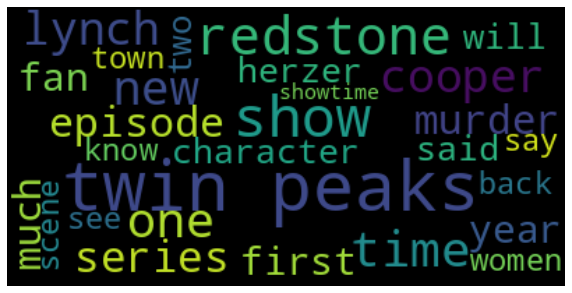

,vector_id,score,title,content,year,publication,category
0,160789,0.836165,'Twin Peaks' Revival Promises Weirdness And Mystery — But Is That Enough?,[Fans are so geeked about Showtime's coming revival of Twin Peaks that they turned a bare-bones promotional video into a viral hit. Co-creator David Lynch appears in a black suit and tie (seemingl...,2016,NPR,radio
1,146486,0.835490,Twin Peaks recap: episode five – is anyone here even human?,"Spoiler alert: this blog is for Twin Peaks viewers who have seen episodes five of The Return, showing on Showtime on the US and Sky Atlantic in the UK. Do not read on unless you have watched., Thi...",2017,Guardian,newspaper
3,54347,0.829033,'Twin Peaks' return piques curiosity,"[ (CNN)The following contains spoilers about the ""Twin Peaks"" premiere., The granddaddy of ""surreal-ity TV"" is back, as ""Twin Peaks"" returned with a two-hour premiere that laid the groundwork for ...",2017,CNN,broadcast
4,60458,0.827623,'Twin Peaks' star set to return in series reboot,"[ (CNN)If you're looking for damn fine coffee (and hot!), the producers of the upcoming ""Twin Peaks"" reboot have just what you're looking for., Fans of the cult 1990 ABC series can breathe easier ...",2015,CNN,broadcast
5,182443,0.827161,"Misty peaks, verdant trees, fresh cherry pie: the real 'Twin Peaks'","Wind whistles through the Douglas fir trees dotting the Washington state horizon, the cascading waters of Snoqualmie Falls crash into a ravine and a freshly baked cherry pie sits atop the counter...",2017,Reuters,wire


In [30]:
plot_summary(summary(twin_peaks_title))

### Twin Peaks - Query 1
**Query: I want articles similar to "Twin Peaks" title published by "Los Angeles Times"**

count    20.000000
mean      0.780488
std       0.036518
min       0.733907
25%       0.743382
50%       0.787766
75%       0.814440
max       0.818497
Name: score, dtype: float64


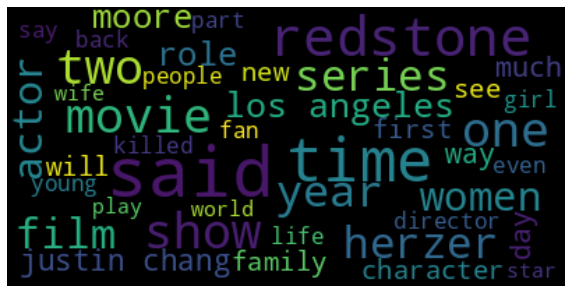

,vector_id,score,title,content,year,publication,category
0,9996,0.818497,The serial killer-thriller ‘Hounds of Love’ tries for female empowerment in its suburban horror tale - LA Times,"The stillness of suburban life is deafening in Perth, Australia, circa 1987 — even more so as teenaged Vicki (Ashleigh Cummings) finds herself duped, drugged and chained to the bed of a serial-kil...",2017,Los Angeles Times,newspaper
1,14027,0.818003,Review: The 'Spectre' of burnout hovers over latest Bond film - LA Times,"It\'s been 53 years since the first James Bond film, ""Dr. No,"" arrived in theaters, and so many have followed in its wake that if you watched all of them back to back without a break, it would tak...",2015,Los Angeles Times,newspaper
2,12524,0.817488,Review: 'Big Sky' is a big void where a thriller could have been - LA Times,"Kyra Sedgwick stars in the film ""Big Sky.""', 'A promising setup is left to wither in the intense Albuquerque sun permeating ""Big Sky,"" a slack agoraphobic thriller marking the English-language deb...",2015,Los Angeles Times,newspaper
3,11484,0.816627,Review: 'Barely Lethal' kicks teen angst over the head with weak spy tale - LA Times,"At one point in ""Barely Lethal,"" a perky teenage special ops agent played by ""True Grit\'s"" Hailee Steinfeld binge-watches ""Mean Girls,"" ""Clueless,"" some John Hughes movies and other titles from t...",2015,Los Angeles Times,newspaper
4,8311,0.814594,Sundance: 'The Big Sick' offers an early cure for the festival blues - LA Times,"The Sundance Film Festival’s early days may have been overshadowed by the one-two punch of Friday’s presidential inauguration and Saturday’s women’s march, but this 33rd annual edition has slowly ...",2017,Los Angeles Times,newspaper


In [31]:
plot_summary(summary(twin_peaks_title, {'publication': {'$eq': 'los angeles times'}}))

### Twin Peaks - Query 2 - Combine filters
**Query: I want articles related to "Twin Peaks" title published by "Verge" and not categorized as longform, nor newspaper.**

count    20.000000
mean      0.739685
std       0.054110
min       0.679908
25%       0.681755
50%       0.757848
75%       0.789679
max       0.801676
Name: score, dtype: float64


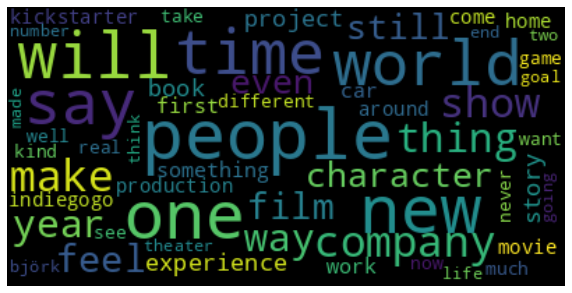

,vector_id,score,title,content,year,publication,category
0,6619,0.801676,The cast of Star Wars: The Force Awakens talk about a new generation of Star Wars women,"""I am the beginning of girl power. Deal with it!""Carrie Fisher is not shy about Princess Leia’s groundbreaking place in Star Wars — and movie — history. During yesterday’s Star Wars: The Fo...",2015,Verge,Reports
1,6958,0.793710,"If David Lynch made a video game, it might look like 'Virginia'","In the upcoming game Virginia, you can sit down in a diner and enjoy a cup of coffee ""black as midnight on a moonless night,"" as if you were Agent Dale Cooper in Twin Peaks.Over the past yea...",2014,Verge,Reports
2,6806,0.792346,We spent Christmas at the Alamo Drafthouse's screening of The Interview,"As soon as I walk up to the flagship Alamo Drafthouse in Austin, Texas, it is very clear to me that I am doing something important for America. Police officers and security staff stand guard...",2014,Verge,Reports
3,7811,0.791583,Dark Matter is a blockbuster read that channels Michael Crichton,"Jason Dressen leads an average life. He's happily married with a teenage son, teaches physics at a local college, and generally gets by, until one night he's kidnapped and drugged. Before he...",2016,Verge,Book Reviews
4,7801,0.790502,Winter Tide subverts Lovecraft’s legacy with sympathetic monsters and terrible humans,"In recent years, the reputation of horror author H.P. Lovecraft has come under fire. On one hand, he’s responsible for an entire branch of cosmic horror that remains extraordinarily influent...",2017,Verge,Book Reviews


In [32]:
verge_longform = {'$and': [
    {'publication': { '$eq': 'verge'}}, 
    {'category': {'$nin': ['longform', 'newspaper']}}]
}
plot_summary(summary(
    twin_peaks_title, 
    verge_longform))

## Alpha Go

Our next example is about finding related articles by an article content related to AlphaGo.

In [33]:
alpha_go_content = test_lookup.content(2)
alpha_go_content[:500]

'      AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s best Go player and confirming that artificial intelligence had mastered the ancient Chinese board game — you may have heard the news delivered in doomsday terms.There was a certain melancholy to Ke Jie’s capitulation, to be sure. The 19-year-old Chinese prodigy declared he would never lose to an AI foll'

count    20.000000
mean      0.922217
std       0.061747
min       0.857244
25%       0.861608
50%       0.925974
75%       0.981914
max       0.984536
Name: score, dtype: float64


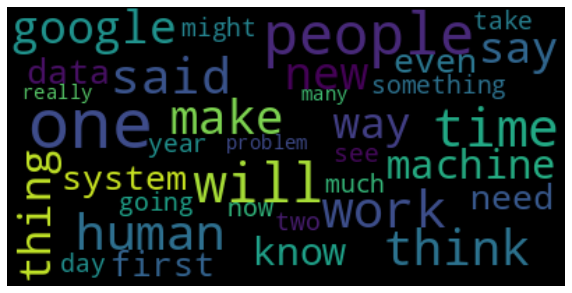

,vector_id,score,title,content,year,publication,category
0,6547,0.984536,Why is Google's Go win such a big deal?,"DeepMind’s dramatic victory over legendary Go player Lee Se-dol earlier today is a huge moment in the history of artificial intelligence, and something many predicted would be decades away. ...",2016,Verge,Reports
1,227683,0.983880,Can A.I. Be Taught to Explain Itself? - The New York Times,"In September, Michal Kosinski published a study that he feared might end his career. The Economist broke the news first, giving it a self-consciously anodyne title: “Advances in A.I. Are Used to S...",2017,New York Times,newspaper
3,104276,0.982894,Google Beats Facebook In The Race To Defeat The Ancient Game Go,[] The board game Go has a deceptively simple premise: Defeat your opponent by using white or black stones to claim the most territory on a 19-by-19 grid. But people have been wrestling with it fo...,2016,Buzzfeed News,general
2,104165,0.982894,"Google Beats Go, The Ancient Game That Computers Couldn’t Crack",[] The board game Go has a deceptively simple premise: Defeat your opponent by using white or black stones to claim the most territory on a 19-by-19 grid. But people have been wrestling with it fo...,2016,Buzzfeed News,general
4,24673,0.982456,The Great A.I. Awakening - The New York Times,"Late one Friday night in early November, Jun Rekimoto, a distinguished professor of human-computer interaction at the University of Tokyo, was online preparing for a lecture when he began to notic...",2017,New York Times,newspaper


In [34]:
plot_summary(summary(alpha_go_content))

### AlphaGo - Query 1 - AND Condition
**Query: I want articles related to AlphaGo content published by "New York Times" after 2017.**

count    20.000000
mean      0.913440
std       0.065203
min       0.842915
25%       0.849907
50%       0.914978
75%       0.976141
max       0.983880
Name: score, dtype: float64


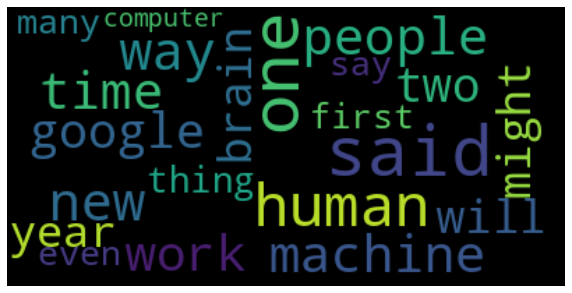

,vector_id,score,title,content,year,publication,category
0,227683,0.983880,Can A.I. Be Taught to Explain Itself? - The New York Times,"In September, Michal Kosinski published a study that he feared might end his career. The Economist broke the news first, giving it a self-consciously anodyne title: “Advances in A.I. Are Used to S...",2017,New York Times,newspaper
1,24673,0.982456,The Great A.I. Awakening - The New York Times,"Late one Friday night in early November, Jun Rekimoto, a distinguished professor of human-computer interaction at the University of Tokyo, was online preparing for a lecture when he began to notic...",2017,New York Times,newspaper
2,227153,0.976870,"Learning to Learn: You, Too, Can Rewire Your Brain - The New York Times","The studio for what is arguably the world’s most successful online course is tucked into a corner of Barb and Phil Oakley’s basement, a converted TV room that smells faintly of cat urine. (At the ...",2017,New York Times,newspaper
3,256786,0.976710,Simple Ways to Be Better at Remembering - The New York Times,"When the sum total of human knowledge rests an arm’s length away in each person’s pocket, why do we have to remember anything anymore? On an average day most of us check our smartphones 47 times, ...",2017,New York Times,newspaper
4,229016,0.976168,Teaching A.I. Systems to Behave Themselves - The New York Times,"SAN FRANCISCO — At OpenAI, the artificial intelligence lab founded by Tesla’s chief executive, Elon Musk, machines are teaching themselves to behave like humans. But sometimes, this goes wrong. Si...",2017,New York Times,newspaper


In [35]:
nyt_2017_plus = {'$and': [
    {'publication': { '$eq': 'new york times'}},
    {'year': {'$gte': 2017}}]
}
plot_summary(summary(
    alpha_go_content, 
    nyt_2017_plus))

### AlphaGo - Query 2 - OR condition
**Query: I want articles related to AlphaGo content published by "Verge" or any related general article.**

count    20.000000
mean      0.916374
std       0.066789
min       0.844695
25%       0.849100
50%       0.922437
75%       0.981386
max       0.984536
Name: score, dtype: float64


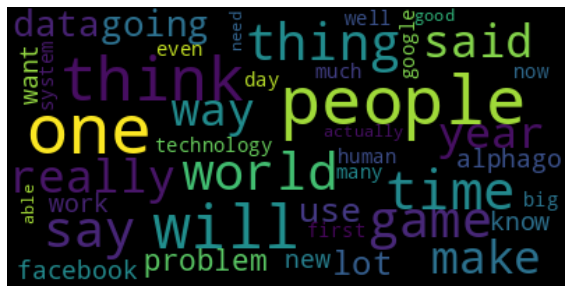

,vector_id,score,title,content,year,publication,category
0,6547,0.984536,Why is Google's Go win such a big deal?,"DeepMind’s dramatic victory over legendary Go player Lee Se-dol earlier today is a huge moment in the history of artificial intelligence, and something many predicted would be decades away. ...",2016,Verge,Reports
1,104276,0.982894,Google Beats Facebook In The Race To Defeat The Ancient Game Go,[] The board game Go has a deceptively simple premise: Defeat your opponent by using white or black stones to claim the most territory on a 19-by-19 grid. But people have been wrestling with it fo...,2016,Buzzfeed News,general
2,104165,0.982894,"Google Beats Go, The Ancient Game That Computers Couldn’t Crack",[] The board game Go has a deceptively simple premise: Defeat your opponent by using white or black stones to claim the most territory on a 19-by-19 grid. But people have been wrestling with it fo...,2016,Buzzfeed News,general
3,21,0.981733,Delivery drones will mean the end of ownership,"The Verge 2021In celebration of our 5th anniversary, this month we’re publishing a series of interviews with innovative leaders about what the next five years hold. To read more about this s...",2016,Verge,Longform
4,74366,0.981426,Why Some Apps Use Fake Progress Bars,"[But as I watched one particularly slick animation, which showed a virtual tax form lighting up line by line—yellow or green—I wondered if what I was seeing actually reflected the progress of a re...",2017,Atlantic,general


In [36]:
verge_or_general = {'$or': [
    {'publication': { '$eq': 'verge'}},
    {'category': {'$eq': 'general'}}]
}
plot_summary(summary(
    alpha_go_content, 
    verge_or_general))

## Black Panther

Our next query is to find a similar articles like one about Black Panther. The first query is without a filtering rules.

In [37]:
black_panther_content = test_lookup.content(5)
black_panther_content[:500]

'      Ahead of Black Panther’s 2018 theatrical release, Marvel turned to Ta-Nehisi Coates to breathe new life into the nation of Wakanda. “I made most of my career analyzing the forces of racism and white supremacy as an idea in America. But what you begin to realize after you do that long enough — you aren’t talking about anything specific. In other words, you aren’t really talking about whether some people have lighter skin or some people have blonde hair or some people have blue eyes or some '

count    18.000000
mean      0.906647
std       0.054499
min       0.850607
25%       0.858350
50%       0.876551
75%       0.963244
max       0.972147
Name: score, dtype: float64


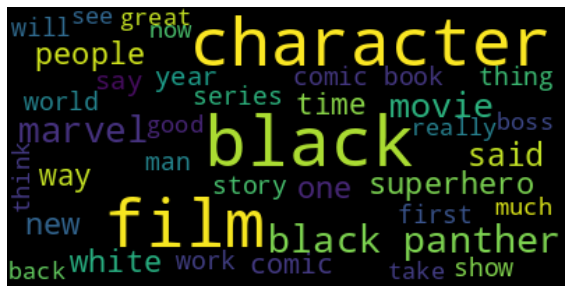

,vector_id,score,title,content,year,publication,category
0,169043,0.972147,2016: Age Of The On-Screen Black Superhero,"[Now that the long wait is over and fans can finally bask in the super-sized, superhero brawl that is Captain America: Civil War, some may overlook something really special about this movie., It h...",2016,NPR,radio
1,150981,0.971157,Teaser trailer for Black Panther: Marvel's original black superhero sharpens his claws,"The first teaser trailer of the Creed director Ryan Coogler’s Marvel adaptation Black Panther revealed a movie that will tackle colonialism and ideas of monarchy, as well as the usual car-flipping...",2017,Guardian,newspaper
3,238438,0.966665,"‘Black Panther’ Brings Hope, Hype and Pride - The New York Times","“I suppose neither of us is used to the spotlight,” a dapper T’Challa, the prince of Wakanda, says upon meeting Natasha Romanova, a.k.a. the Black Widow, in “Captain America: Civil War.” A few sce...",2018,New York Times,newspaper
5,243741,0.963470,The Many Meanings of Black Panther’s Mask - The New York Times,"In an interview with BuzzFeed News in the fall, Sterling K. Brown, a star of “Black Panther,” thrilled at the prospect of children, black and white, dressing up as the title character. “This Hallo...",2018,New York Times,newspaper
6,31503,0.963350,Marvel Comics Cancels Black Lives Matter-Themed 'Black Panther' Due to Poor Sales,"Marvel Comics has canceled its Black Lives Matter-inspired comic book Black Panther &amp The Crew due to poor sales, according to reports.[The comic book — written by activist author Ta-Nehisi Coa...",2017,Breitbart,general


In [38]:
plot_summary(summary(black_panther_content))

### Black Panther - Query 1 - Not In
**Query: I want articles related to "Black Panther" content not published by "Guardian", "Verge", "New York Times", nor "Breitbart". But I'll accapt any related newspaper article.**

count    20.000000
mean      0.908505
std       0.056952
min       0.847293
25%       0.850350
50%       0.914961
75%       0.961939
max       0.972147
Name: score, dtype: float64


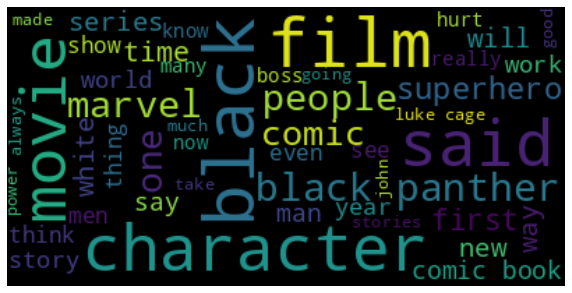

,vector_id,score,title,content,year,publication,category
0,169043,0.972147,2016: Age Of The On-Screen Black Superhero,"[Now that the long wait is over and fans can finally bask in the super-sized, superhero brawl that is Captain America: Civil War, some may overlook something really special about this movie., It h...",2016,NPR,radio
1,150981,0.971157,Teaser trailer for Black Panther: Marvel's original black superhero sharpens his claws,"The first teaser trailer of the Creed director Ryan Coogler’s Marvel adaptation Black Panther revealed a movie that will tackle colonialism and ideas of monarchy, as well as the usual car-flipping...",2017,Guardian,newspaper
2,238438,0.966665,"‘Black Panther’ Brings Hope, Hype and Pride - The New York Times","“I suppose neither of us is used to the spotlight,” a dapper T’Challa, the prince of Wakanda, says upon meeting Natasha Romanova, a.k.a. the Black Widow, in “Captain America: Civil War.” A few sce...",2018,New York Times,newspaper
3,243741,0.963470,The Many Meanings of Black Panther’s Mask - The New York Times,"In an interview with BuzzFeed News in the fall, Sterling K. Brown, a star of “Black Panther,” thrilled at the prospect of children, black and white, dressing up as the title character. “This Hallo...",2018,New York Times,newspaper
4,80752,0.962925,Luke Cage Is Truly a Hero for His Time,"[ For us to continue writing great stories, we need to display ads. , Please select the extension that is blocking ads. , Please follow the steps below, When Cheo Hodari Coker...",2016,Atlantic,general


In [39]:
newspaper_or_notin = {
    '$or': [
        {'category': {'$eq': 'newspaper'}},
        {'publication': {'$nin': ['guardian', 'verge', 'breitbart', "new york times"]}}
    ]
}
plot_summary(summary(black_panther_content, newspaper_or_notin))

### Black Panther - Query 2 - Range AND In

**Query: I want newspaper or general articles related to "Black Panther" content but only between 2016-2017.**

count    18.000000
mean      0.905147
std       0.052710
min       0.851192
25%       0.858350
50%       0.876551
75%       0.960282
max       0.971157
Name: score, dtype: float64


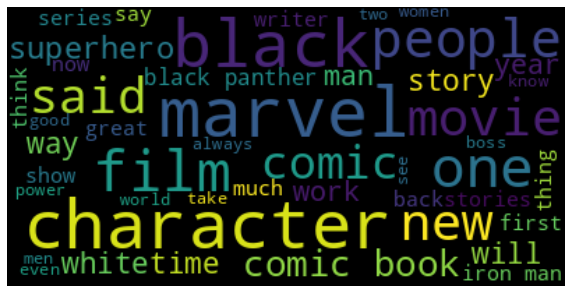

,vector_id,score,title,content,year,publication,category
0,150981,0.971157,Teaser trailer for Black Panther: Marvel's original black superhero sharpens his claws,"The first teaser trailer of the Creed director Ryan Coogler’s Marvel adaptation Black Panther revealed a movie that will tackle colonialism and ideas of monarchy, as well as the usual car-flipping...",2017,Guardian,newspaper
3,31503,0.963350,Marvel Comics Cancels Black Lives Matter-Themed 'Black Panther' Due to Poor Sales,"Marvel Comics has canceled its Black Lives Matter-inspired comic book Black Panther &amp The Crew due to poor sales, according to reports.[The comic book — written by activist author Ta-Nehisi Coa...",2017,Breitbart,general
4,80752,0.962925,Luke Cage Is Truly a Hero for His Time,"[ For us to continue writing great stories, we need to display ads. , Please select the extension that is blocking ads. , Please follow the steps below, When Cheo Hodari Coker...",2016,Atlantic,general
5,157418,0.961610,"Here come the B-list, breathing new life into superhero films","Steven Spielberg’s skill as a film-maker is beyond dispute. As a soothsayer, though, his credentials are shakier. In 2013, he predicted that the superhero movie was heading for the boneyard. “Ther...",2016,Guardian,newspaper
6,200301,0.960810,Marvel says it wants a standalone Black Widow movie. We’ll believe it when we see it.,"\nEven with Captain America: Civil War taking movie theaters by storm, Marvel is keeping its eye on the future. It currently has movies scheduled through 2020, including but not limited to this f...",2016,Vox,general


In [40]:
in_and_range = {
    '$and': [
        {'category': {'$in': ['newspaper', 'general']}},
        {'year': {'$lt': 2018}},
        {'year': {'$gt': 2015}}
    ]
}
plot_summary(summary(black_panther_content, in_and_range))

## Summary
In this example, we covered semantic search of articles using their titles and contents. In the end, we demonstrated the use of condition filters on metadata to narrow down searches without manually filtering results.

We encourage you to try the code with your data. You might want to try different metadata queries and embedding algorithms. Working with a similarity search service makes such experimentations easy. Have fun, and [let us](https://www.pinecone.io/contact/) know if you have any questions or interesting findings.

## Delete the index
Delete the index once you are sure that you do not want to use it anymore. Once the index is deleted, you cannot use it again.

In [ ]:
pinecone.delete_index(index_name)